In [1]:
import numpy as np

import os, sys
sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.sql import *

In [2]:
query_schema_core, query_schema_hosp, query_schema_icu, query_schema_derived, conn = connect_to_database()

Database: mimiciv
Username: postgres
>>>>> Connected to DB <<<<<


# itemid dictionary

In [3]:
query = """
SELECT * FROM mimic_icu.d_items
"""
item_dict = query_sql(conn, query_schema_icu, query)
item_dict.shape

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(3861, 9)

# Orthostatic vital signs for personalized reference

In [4]:
query = """
SELECT * FROM mimic_icu.d_items
WHERE(
	d_items.abbreviation ~~ '%lying'
	OR d_items.abbreviation ~~ '%sitting'
	OR d_items.abbreviation ~~ '%standing'
)
"""
vital_ref = query_sql(conn, query_schema_icu, query)
vital_ref

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,223764,Orthostatic HR lying,Orthostatic HR lying,chartevents,Routine Vital Signs,bpm,Numeric,None,None
1,223765,Orthostatic HR sitting,Orthostatic HR sitting,chartevents,Routine Vital Signs,bpm,Numeric,None,None
2,223766,Orthostatic BPs standing,Orthostatic BPs standing,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
3,224645,Orthostatic BPs lying,Orthostatic BPs lying,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
4,224646,Orthostatic BPs sitting,Orthostatic BPs sitting,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
5,224647,Orthostatic HR standing,Orthostatic HR standing,chartevents,Routine Vital Signs,bpm,Numeric,None,None
6,226092,Orthostatic BPd lying,Orthostatic BPd lying,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
7,226094,Orthostatic BPd sitting,Orthostatic BPd sitting,chartevents,Routine Vital Signs,mmHg,Numeric,None,None
8,226096,Orthostatic BPd standing,Orthostatic BPd standing,chartevents,Routine Vital Signs,mmHg,Numeric,None,None


In [5]:
query = f"""
SELECT * FROM mimic_icu.chartevents
WHERE itemid IN (
	{','.join(map(str, vital_ref['itemid'].values))}
)

ORDER BY subject_id
"""
vital_ref_data = query_sql(conn, query_schema_icu, query)
vital_ref_data.shape

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(4883, 10)

# Select patients with full orthostatic measurements

In [6]:
patient_cohort = []
for sid in vital_ref_data['subject_id'].unique():
    item_list = vital_ref_data.loc[vital_ref_data['subject_id']==sid, 'itemid']
    if set(item_list.values) == set(vital_ref['itemid'].values):
        patient_cohort.append(sid)
len(patient_cohort)

315

In [7]:
_vital_ref_data = vital_ref_data.loc[vital_ref_data['subject_id'].isin(patient_cohort), 
                                     ['subject_id', 'itemid', 'value']]
tmp = _vital_ref_data.groupby(['subject_id', 'itemid']).count()
for i in range(len(tmp)):
    if tmp.iloc[i].item() > 1:
        print(f'{tmp.iloc[i].name}:\t{tmp.iloc[i].item()}')

(10023117, 223765):	2
(10101116, 223765):	2
(10101116, 223766):	2
(10101116, 224646):	2
(10101116, 224647):	2
(10101116, 226094):	2
(10101116, 226096):	2
(10123063, 223764):	6
(10123063, 223765):	6
(10123063, 223766):	7
(10123063, 224645):	6
(10123063, 224646):	6
(10123063, 224647):	7
(10123063, 226092):	6
(10123063, 226094):	6
(10123063, 226096):	7
(10392009, 223764):	2
(10392009, 223765):	2
(10392009, 223766):	3
(10392009, 224645):	3
(10392009, 224646):	3
(10392009, 224647):	2
(10392009, 226092):	3
(10392009, 226094):	3
(10392009, 226096):	3
(10897258, 223764):	3
(10897258, 223765):	3
(10897258, 223766):	3
(10897258, 224645):	3
(10897258, 224646):	3
(10897258, 224647):	3
(10897258, 226092):	3
(10897258, 226094):	3
(10897258, 226096):	3
(11202762, 223764):	2
(11202762, 224645):	2
(11202762, 226092):	2
(11503781, 223764):	2
(11503781, 223765):	2
(11503781, 224645):	2
(11503781, 224646):	2
(11503781, 226092):	2
(11503781, 226094):	2
(11547528, 223764):	2
(11547528, 223765):	2
(11547528,

In [8]:
vital_ref_data[(vital_ref_data['subject_id']==16963267)&(vital_ref_data['itemid']==223764)]['valuenum'].mean()

71.16129032258064

In [9]:
vital_ref_data[(vital_ref_data['subject_id']==16963267)&(vital_ref_data['itemid']==223765)]['valuenum'].mean()

73.5

In [10]:
vital_ref_data[(vital_ref_data['subject_id']==16963267)&(vital_ref_data['itemid']==224647)]['valuenum'].mean()

90.05555555555556

# Patient Information

In [11]:
query = f"""
SELECT * from mimic_core.patients
WHERE subject_id IN (
	{','.join(map(str, patient_cohort))}
)
ORDER BY subject_id
"""
patient_info = query_sql(conn, query_schema_core, query)
patient_info.shape

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(315, 6)

# Select patients between 18-89 years old

In [12]:
patient_info = patient_info[(patient_info['anchor_age']>0)&(patient_info['anchor_age']<91)]
patient_cohort = patient_info['subject_id'].values
patient_info

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10023117,M,53,2170,2011 - 2013,2175-07-20
1,10096391,F,77,2145,2014 - 2016,None
2,10101116,M,22,2129,2011 - 2013,None
3,10110363,M,77,2167,2011 - 2013,None
4,10123063,M,63,2115,2014 - 2016,None
...,...,...,...,...,...,...
310,19821558,M,64,2148,2014 - 2016,None
311,19858031,M,87,2146,2008 - 2010,None
312,19877583,F,39,2117,2017 - 2019,None
313,19917454,M,77,2156,2008 - 2010,None


In [13]:
patient_info[~pd.isnull(patient_info['dod'])].shape

(18, 6)

# Select admissions > 48h with valid discharge location

In [14]:
query = f"""
SELECT * FROM mimic_core.admissions
WHERE(
    hadm_id IN (
        {','.join(map(str, vital_ref_data.loc[vital_ref_data['subject_id'].isin(patient_cohort), 'hadm_id'].unique()))}
    )
    AND
        DATE_PART('day', dischtime-admittime) * 24 + DATE_PART('hour', dischtime-admittime) > 48
)
ORDER BY subject_id
"""
admissions = query_sql(conn, query_schema_icu, query)
admissions.shape

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(277, 15)

In [15]:
admissions = admissions[~pd.isnull(admissions['discharge_location'])]
admissions.shape

(276, 15)

In [16]:
admissions[['hadm_id', 'discharge_location']].groupby('discharge_location').count()

,hadm_id
discharge_location,
ACUTE HOSPITAL,1
AGAINST ADVICE,3
CHRONIC/LONG TERM ACUTE CARE,4
DIED,6
HOME,115
HOME HEALTH CARE,80
HOSPICE,5
OTHER FACILITY,1
PSYCH FACILITY,8


In [17]:
admissions[~pd.isnull(admissions['deathtime'])].shape

(6, 15)

# Patient data: Chartevent

In [18]:
query = f"""
SELECT * FROM mimic_icu.chartevents
WHERE(
    hadm_id IN (
        {','.join(map(str, admissions['hadm_id'].values))}
    )
)
ORDER BY subject_id
"""
chart_data = query_sql(conn, query_schema_icu, query)
chart_data.shape

/home/kai/workspace/env/torch-py38/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(1052455, 10)

In [19]:
chart_selected = {}
for item in chart_data['itemid'].unique():
    num_adm = chart_data[chart_data['itemid']==item]['hadm_id'].unique().shape[0]
    if num_adm > 100:
        chart_selected[item] = num_adm

In [20]:
item_resp = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Respiratory':
        item_resp[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t' +
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' +
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')
            
# remove O2 Delivery Device(s)
del item_resp[226732]

220210	Respiratory	Respiratory Rate:	276	24768
220277	Respiratory	O2 saturation pulseoxymetry:	276	24606
223834	Respiratory	O2 Flow:	164	1987
226732	Respiratory	O2 Delivery Device(s):	271	5186


In [21]:
item_vital = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Routine Vital Signs' \
    and item not in vital_ref['itemid'].values:
        item_vital[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t' +
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' +
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')

220045	Routine Vital Signs	Heart Rate:	276	25854
220048	Routine Vital Signs	Heart Rhythm:	275	22396
220179	Routine Vital Signs	Non Invasive Blood Pressure systolic:	276	20923
220180	Routine Vital Signs	Non Invasive Blood Pressure diastolic:	276	20921
220181	Routine Vital Signs	Non Invasive Blood Pressure mean:	276	20819
223761	Routine Vital Signs	Temperature Fahrenheit:	276	6238
224642	Routine Vital Signs	Temperature Site:	276	6711
224650	Routine Vital Signs	Ectopy Type 1:	273	18742
224651	Routine Vital Signs	Ectopy Frequency 1:	171	2986


In [22]:
item_lab = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Labs':
        item_lab[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t'+
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' +
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')

220228	Labs	Hemoglobin:	272	1651
220545	Labs	Hematocrit (serum):	272	1678
220546	Labs	WBC:	272	1433
220587	Labs	AST:	142	305
220602	Labs	Chloride (serum):	274	1578
220615	Labs	Creatinine (serum):	274	1547
220621	Labs	Glucose (serum):	274	1549
220632	Labs	LDH:	103	195
220635	Labs	Magnesium:	273	1506
220644	Labs	ALT:	142	305
220645	Labs	Sodium (serum):	274	1693
220734	Labs	PH (dipstick):	105	207
225612	Labs	Alkaline Phosphate:	141	292
225624	Labs	BUN:	274	1544
225625	Labs	Calcium non-ionized:	272	1430
225639	Labs	Differential-Basos:	110	175
225640	Labs	Differential-Eos:	110	175
225641	Labs	Differential-Lymphs:	110	175
225642	Labs	Differential-Monos:	110	175
225643	Labs	Differential-Neuts:	110	175
225664	Labs	Glucose finger stick (range 70-100):	171	2342
225668	Labs	Lactic Acid:	113	514
225677	Labs	Phosphorous:	273	1441
225690	Labs	Total Bilirubin:	142	308
227073	Labs	Anion gap:	274	1530
227429	Labs	Troponin-T:	116	258
227442	Labs	Potassium (serum):	274	1617
227443	Labs	HCO3 (serum):	274	

In [23]:
item_alarm = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Alarms':
        item_alarm[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' + 
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')
        
del item_alarm[224168]
del item_alarm[224641]
del item_alarm[226253]
del item_alarm[228305]

220046	Alarms	Heart rate Alarm - High:	276	3416
220047	Alarms	Heart Rate Alarm - Low:	276	3423
223751	Alarms	Non-Invasive Blood Pressure Alarm - High:	276	3242
223752	Alarms	Non-Invasive Blood Pressure Alarm - Low:	276	3242
223769	Alarms	O2 Saturation Pulseoxymetry Alarm - High:	276	3367
223770	Alarms	O2 Saturation Pulseoxymetry Alarm - Low:	276	3385
224161	Alarms	Resp Alarm - High:	276	3381
224162	Alarms	Resp Alarm - Low:	276	3376
224168	Alarms	Parameters Checked:	276	6235
224641	Alarms	Alarms On:	276	6395
226253	Alarms	SpO2 Desat Limit:	274	3294
227240	Alarms	NBP Alarm Source:	276	3211
228305	Alarms	ST Segment Monitoring On:	232	4675


In [24]:
item_pain = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Pain/Sedation':
        item_pain[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' +
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')
        
del item_pain[223792]
del item_pain[228096]
del item_pain[228298]
del item_pain[228299]
del item_pain[229326]

223781	Pain/Sedation	Pain Present:	276	6547
223782	Pain/Sedation	Pain Type:	248	3598
223783	Pain/Sedation	Pain Location:	268	4964
223784	Pain/Sedation	Pain Cause:	208	3306
223791	Pain/Sedation	Pain Level:	251	3757
223792	Pain/Sedation	Pain Management:	229	6052
223794	Pain/Sedation	Pain Level Acceptable:	251	3429
223795	Pain/Sedation	Pain Assessment Method:	220	4847
223796	Pain/Sedation	Untoward Effect:	181	1586
224409	Pain/Sedation	Pain Level Response:	206	1769
228096	Pain/Sedation	Richmond-RAS Scale:	251	4746
228298	Pain/Sedation	Daily Wake Up:	225	2662
228299	Pain/Sedation	Goal Richmond-RAS Scale:	230	3935
228332	Pain/Sedation	Delirium assessment:	219	1976
229326	Pain/Sedation	CAM-ICU MS Change:	149	1447


In [25]:
#!!! Estimate pain from vitals

chart_data[(chart_data['itemid']==223795)&(chart_data['value']=='Change in Vitals')]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
3164,10023117,21133938,38554095,2175-03-21 08:00:00,2175-03-21 07:41:00,223795,Change in Vitals,NaN,None,0
3327,10023117,21133938,38554095,2175-03-21 04:24:00,2175-03-21 04:25:00,223795,Change in Vitals,NaN,None,0
155861,11078706,29037009,38072343,2183-02-23 13:46:00,2183-02-23 13:46:00,223795,Change in Vitals,NaN,None,0
179620,11435410,28044122,37646282,2125-01-05 00:19:00,2125-01-05 00:19:00,223795,Change in Vitals,NaN,None,0
220552,11639347,24125111,31929937,2147-09-24 16:00:00,2147-09-24 18:27:00,223795,Change in Vitals,NaN,None,0
...,...,...,...,...,...,...,...,...,...,...
1030138,19787228,29570125,35856224,2142-07-04 16:34:00,2142-07-04 16:34:00,223795,Change in Vitals,NaN,None,0
1030209,19787228,29570125,35856224,2142-07-04 19:33:00,2142-07-04 20:34:00,223795,Change in Vitals,NaN,None,0
1030254,19787228,29570125,35856224,2142-07-04 20:34:00,2142-07-04 20:35:00,223795,Change in Vitals,NaN,None,0
1030476,19787228,29570125,35856224,2142-07-05 00:21:00,2142-07-05 02:21:00,223795,Change in Vitals,NaN,None,0


In [26]:
item_treat = {}
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100 \
    and item_dict[item_dict['itemid']==item]['category'].item()=='Treatments':
        item_treat[item] = item_dict[item_dict["itemid"]==item]["label"].item()
        print(f'{item}\t' + 
              f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t' +
              f'{item_dict[item_dict["itemid"]==item]["label"].item()}:\t' +
              f'{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')

224080	Treatments	Head of Bed:	275	9466
224082	Treatments	Turn:	276	9841
224084	Treatments	Activity:	122	3177
224086	Treatments	Activity Tolerance:	275	8955
224087	Treatments	Therapeutic Bed:	179	3526
224088	Treatments	Pressure Reducing Device:	208	3402
224089	Treatments	Anti Embolic Device:	250	5886
224093	Treatments	Position:	270	8125
225054	Treatments	Anti Embolic Device Status:	207	4638
225184	Treatments	Eye Care:	116	343
226168	Treatments	Oral Care:	233	1683
228393	Treatments	Bath:	164	795
228868	Treatments	Assistance:	191	7140
229321	Treatments	Activity / Mobility (JH-HLM):	153	6554


In [27]:
for item in np.sort(list(chart_selected.keys())):
    if chart_selected[item] > 100:
        print(f'{item_dict[item_dict["itemid"]==item]["category"].item()}\t\t\t{item_dict[item_dict["itemid"]==item]["label"].item()}:\t{chart_selected[item]}\t{chart_data[chart_data["itemid"]==item].shape[0]}')

Routine Vital Signs			Heart Rate:	276	25854
Alarms			Heart rate Alarm - High:	276	3416
Alarms			Heart Rate Alarm - Low:	276	3423
Routine Vital Signs			Heart Rhythm:	275	22396
Routine Vital Signs			Non Invasive Blood Pressure systolic:	276	20923
Routine Vital Signs			Non Invasive Blood Pressure diastolic:	276	20921
Routine Vital Signs			Non Invasive Blood Pressure mean:	276	20819
Respiratory			Respiratory Rate:	276	24768
Labs			Hemoglobin:	272	1651
Respiratory			O2 saturation pulseoxymetry:	276	24606
Labs			Hematocrit (serum):	272	1678
Labs			WBC:	272	1433
Labs			AST:	142	305
Labs			Chloride (serum):	274	1578
Labs			Creatinine (serum):	274	1547
Labs			Glucose (serum):	274	1549
Labs			LDH:	103	195
Labs			Magnesium:	273	1506
Labs			ALT:	142	305
Labs			Sodium (serum):	274	1693
Labs			PH (dipstick):	105	207
Neurological			GCS - Eye Opening:	276	7078
Alarms			Non-Invasive Blood Pressure Alarm - High:	276	3242
Alarms			Non-Invasive Blood Pressure Alarm - Low:	276	3242
General			Code Status:	1

Labs			INR:	241	1021
Labs			Specific Gravity (urine):	103	204
Adm History/FHPA			Tobacco Use History:	185	423
Restraint/Support Systems			Side Rails:	262	6168
GI/GU			All Medications Tolerated without Adverse Side Effects:	248	2192
Restraint/Support Systems			Safety Measures:	262	51286
Access Lines - Peripheral			18 G Phlebitis Scale:	138	987
Access Lines - Peripheral			18 G Infiltration Scale:	138	979
Access Lines - Peripheral			20 G Phlebitis Scale:	184	1881
Access Lines - Peripheral			20 G Infiltration Scale:	183	1873
Pain/Sedation			Richmond-RAS Scale:	251	4746
Access Lines - Peripheral			18 Gauge placed in the field:	154	1431
Access Lines - Peripheral			20 Gauge placed in the field:	195	2529
Adm History/FHPA			Insulin pump:	217	562
Pain/Sedation			Daily Wake Up:	225	2662
Pain/Sedation			Goal Richmond-RAS Scale:	230	3935
Alarms			ST Segment Monitoring On:	232	4675
Pain/Sedation			Delirium assessment:	219	1976
Treatments			Bath:	164	795
Neurological			Commands Response:	207	5093
Neu

# Admission weight

In [28]:
chart_data[chart_data['itemid']==226512]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
3374,10023117,21133938,38554095,2175-03-21 03:20:00,2175-03-26 15:47:00,226512,74.3,74.3,kg,0
7739,10096391,25591360,30492740,2145-12-02 22:21:00,2145-12-02 22:39:00,226512,68.2,68.2,kg,0
11867,10101116,28111170,31553058,2129-01-19 03:21:00,2129-01-19 04:01:00,226512,68.9,68.9,kg,0
14710,10110363,21842992,38812969,2167-06-14 17:53:00,2167-06-14 20:10:00,226512,97.3,97.3,kg,0
17072,10123063,24799331,34259567,2115-07-09 23:12:00,2115-07-13 10:47:00,226512,71,71.0,kg,0
...,...,...,...,...,...,...,...,...,...,...
1041992,19821558,22088283,33781293,2150-01-24 11:30:00,2150-01-24 13:35:00,226512,59.7,59.7,kg,0
1042335,19858031,21425327,36486323,2151-10-04 07:46:00,2151-10-04 11:16:00,226512,88.2,88.2,kg,0
1043342,19877583,24675179,31927556,2117-04-24 19:58:00,2117-04-24 20:03:00,226512,60,60.0,kg,0
1045106,19917454,27342711,36620660,2166-02-03 10:29:00,2166-02-03 10:37:00,226512,80.9,80.9,kg,0


In [29]:
chart_data[chart_data['itemid']==226512]['hadm_id'].unique().shape

(276,)

# Save data

In [30]:
os.path.abspath('')

'/home/kai/workspace/DHM/experiments/anomaly_detection_mimic/notebooks'

In [31]:
# Patient information
columns = ['subject_id', 'gender', 'age', 'admission_weight',
           'hadm_id', 'admittime', 'dischtime', 'admission_type', 'admission_location', 'discharge_location', 
           'deathtime']
adm_schema_col = ['subject_id', 'hadm_id', 'admittime', 'dischtime', 
                  'admission_type', 'admission_location', 'discharge_location', 
                  'deathtime']
patient_schema_col = ['gender', 'age']
chartevent_schema_col = ['admission_weight']

df_info = pd.DataFrame(columns=[columns])
df_info = admissions[adm_schema_col].sort_values('hadm_id').copy().reset_index(drop=True)

for sid in df_info['subject_id'].values.flatten():
    df_info.loc[df_info['subject_id']==sid, 'gender'] = \
        patient_info.loc[patient_info['subject_id']==sid, 'gender'].item()
    df_info.loc[df_info['subject_id']==sid, 'age'] = \
        patient_info.loc[patient_info['subject_id']==sid, 'anchor_age'].item()
    
for adm in df_info['hadm_id'].values.flatten():
    df_info.loc[df_info['hadm_id']==adm, 'admission_weight'] = \
        chart_data.loc[(chart_data['hadm_id']==adm) & (chart_data['itemid']==226512), 'valuenum'].mean()

In [32]:
# Chartevents
df_chart = pd.DataFrame(columns=chart_data.columns)

selected_items = [item_vital, item_resp, item_lab,
                 item_alarm, item_pain, item_treat]

for item_list in selected_items:
    for iid in item_list:
        data = chart_data[chart_data['itemid']==iid]
        df_chart = pd.concat([df_chart, data])
        
df_chart = pd.concat([df_chart, vital_ref_data[vital_ref_data['hadm_id'].isin(admissions['hadm_id'])]])

df_chart = df_chart.sort_values(['hadm_id', 'charttime']).reset_index(drop=True)
df_chart.shape

(371923, 10)

In [33]:
from pathlib import Path

save_folder = os.path.join(os.path.abspath(''), '..', 'data')
Path(save_folder).mkdir(parents=True, exist_ok=True)

df_info.to_csv(os.path.join(save_folder, 'patient_information'))
df_chart.to_csv(os.path.join(save_folder, 'patient_chartdata'))
item_dict.to_csv(os.path.join(save_folder, 'item_dict'))
vital_ref.to_csv(os.path.join(save_folder, 'vital_ref_dict'))

selected_items = {
    'vital': item_vital,
    'resp': item_resp,
    'lab': item_lab,
    'treatment': item_treat,
    'pain': item_pain
}

np.save(os.path.join(save_folder, 'selected_items'), selected_items)

# Visualize data

In [34]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [35]:
def locate_data(data, iid, charttime):
    try:
        val = data[(data['itemid']==iid)&(data['charttime']==charttime)]['valuenum'].item()
    except:
        df = data[data['itemid']==iid]

        _charttime = df.loc[[(abs(pd.to_datetime(df_tmp['charttime'])-ct.to_datetime64())).idxmin()]]\
                    ['charttime'].item()
        val = data[(data['itemid']==iid)&(data['charttime']==_charttime)]['valuenum'].item()
    return val, charttime


def plot_data(gs, data, data_item):
    for iid in data_item:


        ax = plt.subplot(gs)
        if item_dict[item_dict['itemid']==iid]['category'].item() == 'Labs':
            ax.scatter(data[data['itemid']==iid]['charttime'], data[data['itemid']==iid]['valuenum'], 
                     label=data_item[iid])
            
        elif item_dict[item_dict['itemid']==iid]['category'].item() == 'Treatments':
            for d in data[data['itemid']==iid].iterrows():
                    ax.axvline(d[1]['charttime'], color='y')    
            
#         elif item_dict[item_dict['itemid']==iid]['category'].item() == 'Alarms':
#             for d in data[data['itemid']==iid].iterrows():
#                 charttime = d[1]['charttime']
#                 # Heart rate alarm
#                 if iid in [220046, 220047]:
#                     val, ct = locate_data(data, 220045, charttime)
#                     ax.scatter(ct, 
#                                val, 
#                                color='y',
#                                marker='^',
#                                s=100,
#                               )
#                     ax.axvline(ct, color='y')
                
#                 # NIBP alarm
#                 elif iid == 227240:
#                     if d[1]['value'] == 'Systolic':
#                         val, ct = locate_data(data, 220179, charttime)
#                     elif d[1]['value'] == 'Diastolic':
#                         val, ct = locate_data(data, 220180, charttime)
#                     elif d[1]['value'] == 'Mean':
#                         val, ct = locate_data(data, 220181, charttime)
#                         xd = data[(data['itemid']==220181)
#                                   &(data['charttime']==charttime)]['valuenum'].item()
#                     else:
#                         raise AssertionError('Unsupport NIBP type.')
                        
#                     ax.scatter(ct, 
#                                val, 
#                                color='y',
#                                marker='^',
#                                s=100
#                               )
#                     ax.axvline(ct, color='y')


#                 # SpO2 alarm
#                 elif iid in [223769, 223770]:
#                     val, ct = locate_data(data, 220277, charttime)
#                     ax.scatter(ct, 
#                                val, 
#                                color='y',
#                                marker='^',
#                                s=100
#                               )
#                     ax.axvline(ct, color='y')
                
#                 # Respiration alarm
#                 elif iid in [224161, 224162]:
#                     val, ct = locate_data(data, 220210, charttime)
#                     ax.scatter(ct, 
#                                val, 
#                                color='y',
#                                marker='^',
#                                s=100
#                               )
#                     ax.axvline(ct, color='y')
                
#                 else:
#                     raise AssertionError(f'Unsupported alarm type: {iid}.')
                    
        
        elif item_dict[item_dict['itemid']==iid]['category'].item() == 'Pain/Sedation':
#             print(f'Pain event: {iid}')
            for d in data[data['itemid']==iid].iterrows():
#                 print(d[1]['itemid'])
                if d[1]['value'] == 'Yes':
                    ax.axvline(d[1]['charttime'], color='r')    
        
            
        else:
            if item_dict[item_dict['itemid']==iid]['param_type'].item()=='Text':
                continue
            ax.plot(data[data['itemid']==iid]['charttime'], data[data['itemid']==iid]['valuenum'], 
                     label=data_item[iid])
        

                    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

23836412


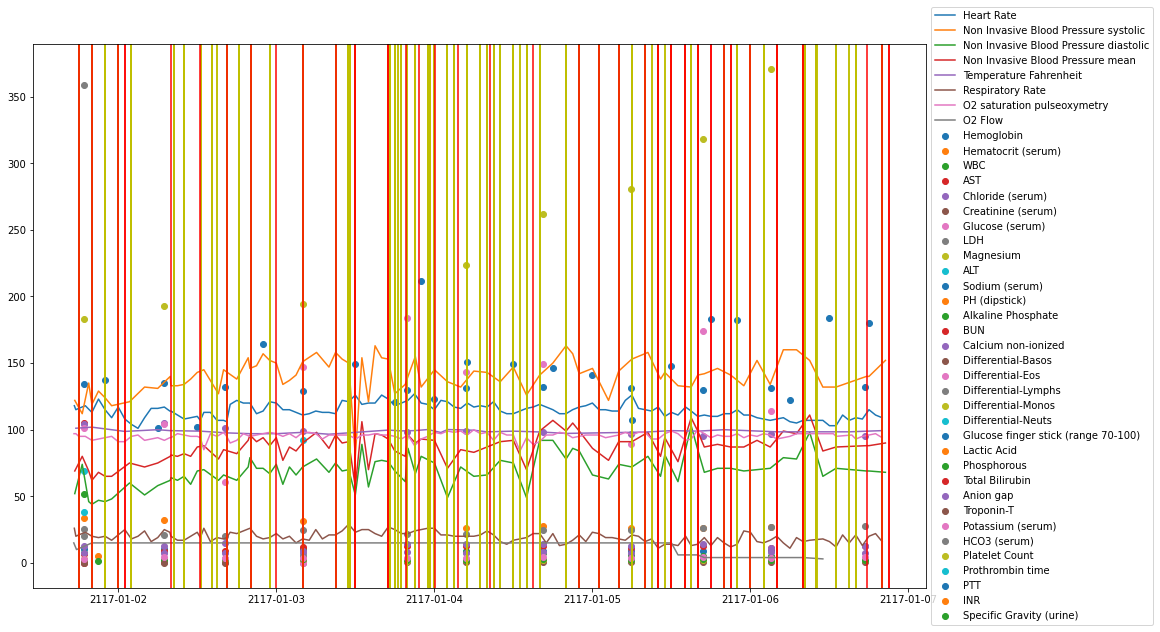

In [37]:
adm = df_chart['hadm_id'].unique()[101]
# adm = adm_pain[0]
print(adm)
example = df_chart[df_chart['hadm_id']==adm]


fig = plt.figure(figsize=(16,10))

gs = gridspec.GridSpec(1, 1) 
# gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# for iid in item_vital:
#     if item_dict[item_dict['itemid']==iid]['param_type'].item()=='Text':
#         continue

#     plt.plot(example[example['itemid']==iid]['charttime'], example[example['itemid']==iid]['valuenum'], 
#              label=item_vital[iid])

plot_data(gs[0], example, item_vital)
plot_data(gs[0], example, item_resp)
plot_data(gs[0], example, item_lab)
plot_data(gs[0], example, item_treat)
plot_data(gs[0], example, item_pain)


In [38]:
item_treat

{224080: 'Head of Bed',
 224082: 'Turn',
 224084: 'Activity',
 224086: 'Activity Tolerance',
 224087: 'Therapeutic Bed',
 224088: 'Pressure Reducing Device',
 224089: 'Anti Embolic Device',
 224093: 'Position',
 225054: 'Anti Embolic Device Status',
 225184: 'Eye Care',
 226168: 'Oral Care',
 228393: 'Bath',
 228868: 'Assistance',
 229321: 'Activity / Mobility (JH-HLM)'}

In [49]:
for iid in item_treat:
    print(f'---------------{item_treat[iid]}---------------')
    print(df_chart[df_chart['itemid']==iid].groupby(['value']).count()['hadm_id']) 
    print()

---------------Head of Bed---------------
value
---                264
15 Degrees         830
30 Degrees        5311
45 Degrees        1920
90 Degrees         742
Flat in Bed        205
Reverse T-berg     181
Trendelenberg       13
Name: hadm_id, dtype: int64

---------------Turn---------------
value
Back                    758
Left Side               360
Logroll                  29
Logroll x4 Assist         3
Per hospital policy      50
Prone                     3
Right Side              374
Side to Side           4056
Turns by Self          4208
Name: hadm_id, dtype: int64

---------------Activity---------------
value
Ambulate          75
Bed as Chair      17
Bedrest         2361
Chair            433
Commode          225
Dangle            66
Name: hadm_id, dtype: int64

---------------Activity Tolerance---------------
value
Fair               374
Good              2389
Poor                42
Tolerated Well    6150
Name: hadm_id, dtype: int64

---------------Therapeutic Bed-----------

In [43]:
item_pain

{223781: 'Pain Present',
 223782: 'Pain Type',
 223783: 'Pain Location',
 223784: 'Pain Cause',
 223791: 'Pain Level',
 223794: 'Pain Level Acceptable',
 223795: 'Pain Assessment Method',
 223796: 'Untoward Effect',
 224409: 'Pain Level Response',
 228332: 'Delirium assessment'}

In [51]:
for iid in item_pain:
    print(f'---------------{item_pain[iid]}---------------')
    print(df_chart[df_chart['itemid']==iid].groupby(['value']).count()['hadm_id']) 
    print()

---------------Pain Present---------------
value
No     3991
Yes    2556
Name: hadm_id, dtype: int64

---------------Pain Type---------------
value
Aching           571
Burning           51
Chronic           13
Constant         731
Cramping          70
Crushing           2
Dull             152
Gassy             18
Headache          60
Heavy              4
Intermittent     361
Nagging            2
Neuropathic        2
None            1252
Pressure          42
Radiating         10
Sharp            126
Shooting           7
Sore Throat        2
Stabbing          25
Throbbing         97
Name: hadm_id, dtype: int64

---------------Pain Location---------------
value
Abdominal                349
Back                     366
Both Legs                 23
Chest Pain               118
Eye                       12
Facial                    13
Generalized               82
Genital area               3
Headache                 863
Incisional               540
Jaw                        6
Left Arm     

In [60]:
3/0.65

4.615384615384615

In [406]:
df_info


,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,discharge_location,deathtime,gender,age,admission_weight
0,12527107,20002636,2148-02-21 18:13:00,2148-03-01 17:00:00,OBSERVATION ADMIT,EMERGENCY ROOM,HOME,NaT,M,48.0,96.10
1,12375699,20031565,2128-04-16 16:17:00,2128-05-23 17:07:00,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,NaT,F,71.0,43.15
2,13361709,20041342,2188-12-29 15:02:00,2189-01-04 13:27:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,NaT,F,79.0,70.40
3,16305060,20041808,2172-06-24 21:52:00,2172-07-04 16:00:00,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,NaT,M,59.0,104.10
4,13952663,20091699,2181-10-06 02:28:00,2181-10-10 15:30:00,OBSERVATION ADMIT,AMBULATORY SURGERY TRANSFER,HOME HEALTH CARE,NaT,F,77.0,75.00
...,...,...,...,...,...,...,...,...,...,...,...
271,12884349,29785449,2163-07-29 14:42:00,2163-08-01 18:17:00,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,NaT,M,77.0,75.00
272,18007631,29816282,2112-08-12 16:46:00,2112-08-16 15:00:00,EW EMER.,EMERGENCY ROOM,HOME,NaT,F,80.0,68.70
273,15124644,29850599,2169-10-29 00:00:00,2169-11-19 16:30:00,URGENT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,NaT,M,56.0,163.00
274,13568806,29900843,2124-10-24 21:19:00,2124-11-22 14:30:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,NaT,M,53.0,76.30
